# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the data
You'll be using two datasets in this project:
MNIST
CelebA
Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA. Running the GANs on MNIST will allow you to see how well your model trains sooner.
If you're using FloydHub, set data_dir to "/input" and use the FloydHub data ID "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the MNIST dataset contains images of handwritten digits. You can view the first number of examples by changing show_n_images.

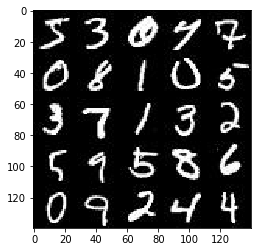

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The CelebFaces Attributes Dataset (CelebA) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations. You can view the first number of examples by changing show_n_images.

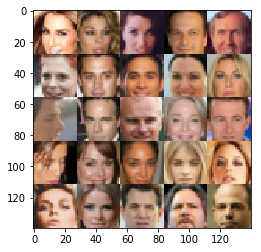

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels (RGB color channel).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
* model_inputs
* discriminator
* generator
* model_loss
* model_opt
* train

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/krypten/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the model_inputs function to create TF Placeholders for the Neural Network. It should create the following placeholders:
* Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
* Z input placeholder with rank 2 using z_dim.
* Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='z_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_data = tf.placeholder(tf.float32, name='learning_data')
    
    return real_input, z_input, learning_data

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement discriminator to create a discriminator neural network that discriminates on images. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer : (28x28x3)
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        # Hidden Layer 1 : (14x14x64)
        h2 = tf.layers.conv2d(h1, 128, 5, strides=1, padding='same')
        h2 = tf.maximum(alpha * h2, h2)
        # Hidden Layer 2 : (14x14x256)
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.maximum(alpha * h3, h3)
        # Hidden Layer 3 : (7x7x256)
        flat = tf.reshape(h3, (-1, 7*7*256))
        # Flat layer : (7*7*256)
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
        return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement generator to generate an image using z. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x out_channel_dim images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7 * 7 * 256)

        # Reshape it to start the convolution network
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1) # LRelu
        # Hidden Layer 1 : (7x7x256)

        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=1, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # Hidden Layer 2 : (7x7x128)
        
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # Hidden Layer 3 : (14x14x64)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=2, padding='same')
        # Output Layer : (28x28x3)
        
        output = tf.tanh(logits)
        return output

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement model_loss to build the GANs for training and calculate the loss. The function should return a tuple of (discriminator loss, generator loss). Use the following functions you implemented:
* discriminator(images, reuse=False)
* generator(z, out_channel_dim, is_train=True)

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement model_opt to create the optimization operations for the GANs. Use tf.trainable_variables to get all the trainable variables. Filter the variables with names that are in the discriminator and generator scope names. The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Trainable Variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement train to build and train the GANs. Use the following functions you implemented:
* model_inputs(image_width, image_height, image_channels, z_dim)
* model_loss(input_real, input_z, out_channel_dim)
* model_opt(d_loss, g_loss, learning_rate, beta1)

Use the show_generator_output to show generator output while you train. Running show_generator_output for every batch will drastically increase training time and increase the size of the notebook. It's recommended to print the generator output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every=100, n_images=25):
    steps = 0
    # Define Image dimensions
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Define model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Input
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                _ = sess.run(g_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                
                # Show generator output
                if (steps % show_every == 0):
                    # Plot generator output
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                if (steps % 10 == 0):
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(steps % batch_size, batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                steps += 1  

### MNIST
Test your GANs architecture on MNIST. After 2 epochs, the GANs should be able to generate images that look like handwritten digits. Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

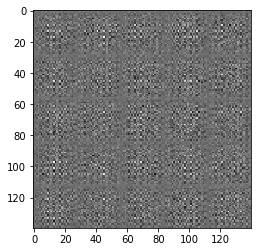

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.2634... Generator Loss: 0.5222
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.1550... Generator Loss: 0.6982
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.4756... Generator Loss: 1.8010
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.3802... Generator Loss: 0.4339
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.8046... Generator Loss: 1.4765
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.5530... Generator Loss: 0.4937
Epoch 1/2... Batch 28/32... Discriminator Loss: 2.6657... Generator Loss: 0.0835
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.2921... Generator Loss: 0.6894
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.2222... Generator Loss: 0.7081
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.6628... Generator Loss: 0.2786


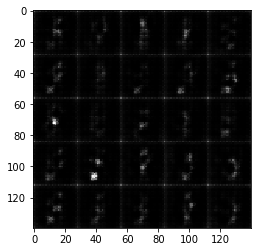

Epoch 1/2... Batch 4/32... Discriminator Loss: 1.4883... Generator Loss: 0.7581
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.1367... Generator Loss: 0.7995
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.0708... Generator Loss: 0.8251
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.0920... Generator Loss: 1.0722
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.2653... Generator Loss: 1.0691
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.6578... Generator Loss: 0.3827
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0904... Generator Loss: 0.7927
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.3442... Generator Loss: 0.9345
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.0987... Generator Loss: 0.8587
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.3657... Generator Loss: 1.1835


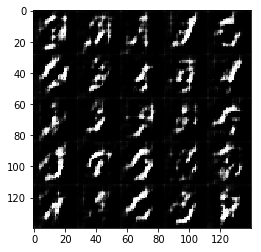

Epoch 1/2... Batch 8/32... Discriminator Loss: 1.4007... Generator Loss: 0.7539
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2363... Generator Loss: 0.6708
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1065... Generator Loss: 0.7591
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.2724... Generator Loss: 0.7574
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3578... Generator Loss: 0.8931
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.3540... Generator Loss: 0.6747
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.0878... Generator Loss: 0.7420
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2262... Generator Loss: 0.7693
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1667... Generator Loss: 0.9553
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1388... Generator Loss: 0.8453


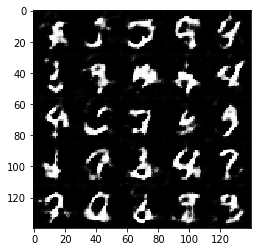

Epoch 1/2... Batch 12/32... Discriminator Loss: 1.4882... Generator Loss: 0.6123
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.0574... Generator Loss: 0.8940
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3015... Generator Loss: 0.7031
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2579... Generator Loss: 0.7369
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2067... Generator Loss: 0.9717
Epoch 1/2... Batch 30/32... Discriminator Loss: 0.9452... Generator Loss: 1.1088
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.3770... Generator Loss: 0.4898
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3035... Generator Loss: 0.6185
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2044... Generator Loss: 1.3613
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.1801... Generator Loss: 0.8595


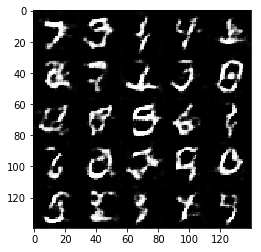

Epoch 1/2... Batch 16/32... Discriminator Loss: 1.1286... Generator Loss: 1.1243
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.3263... Generator Loss: 1.1289
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1375... Generator Loss: 0.7092
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3610... Generator Loss: 0.6862
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.2241... Generator Loss: 0.9740
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2057... Generator Loss: 0.7901
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.1130... Generator Loss: 0.9977
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2319... Generator Loss: 0.7587
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.2499... Generator Loss: 0.7189
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.1817... Generator Loss: 0.9793


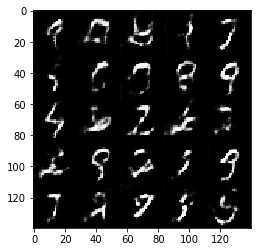

Epoch 1/2... Batch 20/32... Discriminator Loss: 1.5528... Generator Loss: 0.5079
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1563... Generator Loss: 0.8365
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.2057... Generator Loss: 0.6491
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3309... Generator Loss: 0.9615
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1748... Generator Loss: 0.7805
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.4544... Generator Loss: 0.4924
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.0126... Generator Loss: 1.1446
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.1689... Generator Loss: 0.7216
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1343... Generator Loss: 0.8215
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.1756... Generator Loss: 0.8454


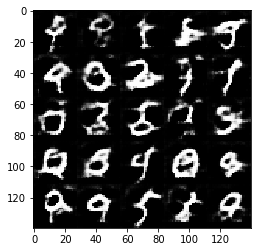

Epoch 1/2... Batch 24/32... Discriminator Loss: 1.3893... Generator Loss: 0.9881
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2863... Generator Loss: 0.9056
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.2495... Generator Loss: 0.9504
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.0252... Generator Loss: 0.9146
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3373... Generator Loss: 0.5684
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2246... Generator Loss: 0.7447
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.1826... Generator Loss: 1.1916
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1284... Generator Loss: 0.8562
Epoch 1/2... Batch 8/32... Discriminator Loss: 0.9481... Generator Loss: 1.1410
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.4837... Generator Loss: 0.5869


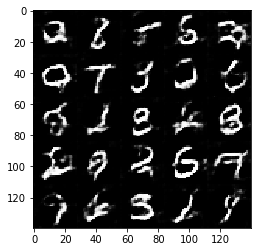

Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2571... Generator Loss: 0.8915
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.4378... Generator Loss: 0.7684
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3817... Generator Loss: 0.6484
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.1417... Generator Loss: 0.8812
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1117... Generator Loss: 0.6986
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2011... Generator Loss: 0.6870
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.0367... Generator Loss: 0.8357
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1007... Generator Loss: 1.0056
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.0093... Generator Loss: 0.9034
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2265... Generator Loss: 0.8819


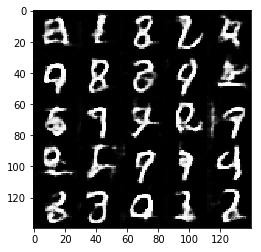

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3653... Generator Loss: 1.3420
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2215... Generator Loss: 0.9197
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.1609... Generator Loss: 0.8127
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1951... Generator Loss: 0.8003
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.1456... Generator Loss: 0.7034
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.0221... Generator Loss: 0.8433
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.4247... Generator Loss: 0.5362
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.1313... Generator Loss: 0.7655
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.1191... Generator Loss: 1.3722
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.0389... Generator Loss: 0.9331


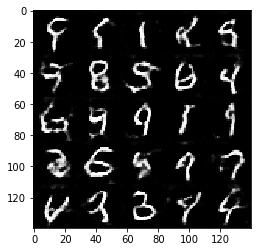

Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1096... Generator Loss: 0.8358
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.0786... Generator Loss: 1.1609
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.0064... Generator Loss: 1.0143
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2632... Generator Loss: 0.9254
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.1933... Generator Loss: 0.6585
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.1681... Generator Loss: 0.6935
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.2411... Generator Loss: 1.2144
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2380... Generator Loss: 0.7316
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.1506... Generator Loss: 0.9688
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.2593... Generator Loss: 1.0338


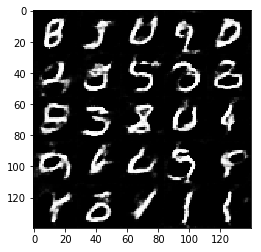

Epoch 1/2... Batch 8/32... Discriminator Loss: 1.0740... Generator Loss: 0.9809
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2486... Generator Loss: 0.7094
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1386... Generator Loss: 0.7341
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0377... Generator Loss: 0.7844
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.0079... Generator Loss: 1.0332
Epoch 1/2... Batch 26/32... Discriminator Loss: 0.9306... Generator Loss: 1.0254
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.0124... Generator Loss: 0.9482
Epoch 1/2... Batch 14/32... Discriminator Loss: 0.9923... Generator Loss: 0.8876
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1348... Generator Loss: 0.8777
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1042... Generator Loss: 0.6830


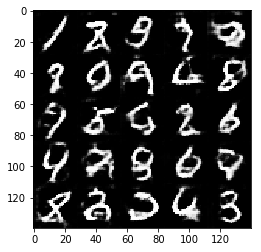

Epoch 1/2... Batch 12/32... Discriminator Loss: 1.1492... Generator Loss: 0.9802
Epoch 1/2... Batch 22/32... Discriminator Loss: 0.9698... Generator Loss: 0.8196
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0913... Generator Loss: 0.9802
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2817... Generator Loss: 0.8519
Epoch 1/2... Batch 20/32... Discriminator Loss: 0.9298... Generator Loss: 0.9535
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1337... Generator Loss: 0.8471
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.1540... Generator Loss: 0.6948
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.0980... Generator Loss: 0.7579
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.0872... Generator Loss: 0.8597
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.1879... Generator Loss: 0.7681


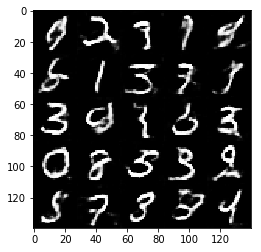

Epoch 1/2... Batch 16/32... Discriminator Loss: 1.2745... Generator Loss: 0.6475
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2230... Generator Loss: 0.8052
Epoch 1/2... Batch 4/32... Discriminator Loss: 0.9919... Generator Loss: 1.0945
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.1996... Generator Loss: 0.8120
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.2111... Generator Loss: 1.2012
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2429... Generator Loss: 0.6669
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.0890... Generator Loss: 0.7743
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2793... Generator Loss: 0.6127
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.1743... Generator Loss: 0.7493
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.1875... Generator Loss: 0.7752


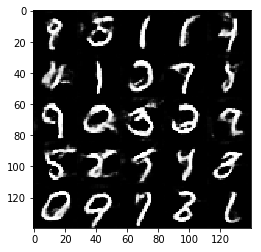

Epoch 1/2... Batch 20/32... Discriminator Loss: 1.0012... Generator Loss: 0.9055
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.0277... Generator Loss: 0.8623
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.2693... Generator Loss: 1.4416
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.1965... Generator Loss: 0.8239
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1815... Generator Loss: 0.5889
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0656... Generator Loss: 1.3684
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.0481... Generator Loss: 1.1262
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.0523... Generator Loss: 0.8740
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1395... Generator Loss: 1.0904
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2526... Generator Loss: 0.9382


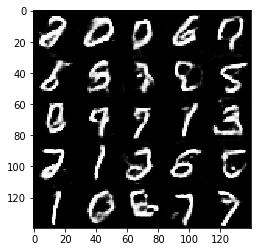

Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1474... Generator Loss: 1.0676
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.0556... Generator Loss: 1.1345
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.3095... Generator Loss: 0.8294
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.1024... Generator Loss: 1.0379
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0045... Generator Loss: 1.1306
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.1819... Generator Loss: 0.7153
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3303... Generator Loss: 0.4779
Epoch 1/2... Batch 30/32... Discriminator Loss: 0.9781... Generator Loss: 1.3365
Epoch 1/2... Batch 8/32... Discriminator Loss: 0.8732... Generator Loss: 1.0671
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.7754... Generator Loss: 1.8239


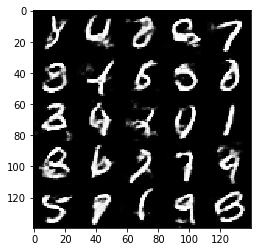

Epoch 1/2... Batch 28/32... Discriminator Loss: 1.0934... Generator Loss: 0.7995
Epoch 1/2... Batch 6/32... Discriminator Loss: 0.9984... Generator Loss: 1.1884
Epoch 1/2... Batch 16/32... Discriminator Loss: 0.8463... Generator Loss: 1.1970
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2001... Generator Loss: 0.9937
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.4044... Generator Loss: 0.5263
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.0365... Generator Loss: 0.7370
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.0649... Generator Loss: 1.4293
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.0724... Generator Loss: 1.1378
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.2869... Generator Loss: 0.6267
Epoch 1/2... Batch 22/32... Discriminator Loss: 0.9952... Generator Loss: 1.2698


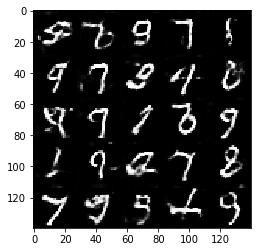

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.1410... Generator Loss: 1.0657
Epoch 1/2... Batch 10/32... Discriminator Loss: 0.9609... Generator Loss: 0.9609
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.0474... Generator Loss: 1.1480
Epoch 1/2... Batch 30/32... Discriminator Loss: 0.9940... Generator Loss: 0.7842
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.0829... Generator Loss: 0.9900
Epoch 1/2... Batch 18/32... Discriminator Loss: 0.9566... Generator Loss: 1.2389
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1366... Generator Loss: 0.9152
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0448... Generator Loss: 0.9435
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3851... Generator Loss: 0.4951
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.1621... Generator Loss: 1.4248


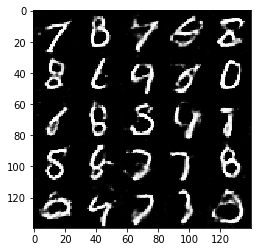

Epoch 1/2... Batch 4/32... Discriminator Loss: 1.0084... Generator Loss: 0.8329
Epoch 1/2... Batch 14/32... Discriminator Loss: 0.8929... Generator Loss: 1.1725
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1182... Generator Loss: 1.3699
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2130... Generator Loss: 0.9657
Epoch 1/2... Batch 12/32... Discriminator Loss: 0.9697... Generator Loss: 1.1029
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.0600... Generator Loss: 0.9448
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0441... Generator Loss: 0.8530
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.4330... Generator Loss: 1.2785
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3506... Generator Loss: 0.6170
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.0249... Generator Loss: 1.0788


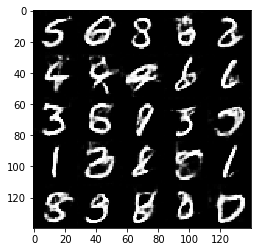

Epoch 1/2... Batch 8/32... Discriminator Loss: 1.0596... Generator Loss: 0.6997
Epoch 1/2... Batch 18/32... Discriminator Loss: 0.9455... Generator Loss: 1.0208
Epoch 1/2... Batch 28/32... Discriminator Loss: 0.9926... Generator Loss: 0.8015
Epoch 1/2... Batch 6/32... Discriminator Loss: 0.9416... Generator Loss: 0.9314
Epoch 1/2... Batch 16/32... Discriminator Loss: 0.8758... Generator Loss: 1.1864
Epoch 1/2... Batch 26/32... Discriminator Loss: 0.9986... Generator Loss: 0.9759
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.0726... Generator Loss: 1.0781
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2939... Generator Loss: 0.6481
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.1201... Generator Loss: 0.7035
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.2905... Generator Loss: 0.5487


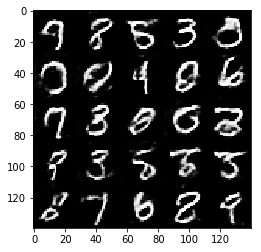

Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9645... Generator Loss: 0.9184
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9887... Generator Loss: 1.2766
Epoch 2/2... Batch 0/32... Discriminator Loss: 1.1047... Generator Loss: 0.7156
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.1229... Generator Loss: 1.3026
Epoch 2/2... Batch 20/32... Discriminator Loss: 1.0716... Generator Loss: 0.9638
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0000... Generator Loss: 0.6701
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9253... Generator Loss: 0.8061
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.1461... Generator Loss: 1.0082
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.0040... Generator Loss: 1.1204
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.2847... Generator Loss: 0.6465


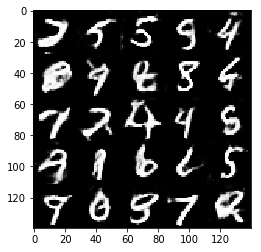

Epoch 2/2... Batch 16/32... Discriminator Loss: 1.2326... Generator Loss: 0.7391
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.2803... Generator Loss: 0.6849
Epoch 2/2... Batch 4/32... Discriminator Loss: 1.0830... Generator Loss: 0.8026
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.0826... Generator Loss: 1.2954
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2206... Generator Loss: 0.6905
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.0329... Generator Loss: 1.9034
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9380... Generator Loss: 0.9078
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.0658... Generator Loss: 0.7119
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.8638... Generator Loss: 1.2870
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9284... Generator Loss: 1.4295


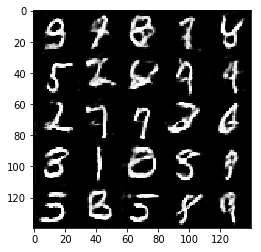

Epoch 2/2... Batch 20/32... Discriminator Loss: 1.0071... Generator Loss: 0.9379
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.8474... Generator Loss: 1.0744
Epoch 2/2... Batch 8/32... Discriminator Loss: 1.1434... Generator Loss: 0.9351
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0031... Generator Loss: 1.1971
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.0292... Generator Loss: 0.8382
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.1304... Generator Loss: 1.2486
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.3341... Generator Loss: 0.4935
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0367... Generator Loss: 1.0510
Epoch 2/2... Batch 4/32... Discriminator Loss: 1.0648... Generator Loss: 0.7465
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.0795... Generator Loss: 0.5824


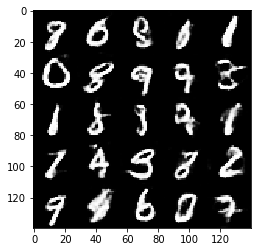

Epoch 2/2... Batch 24/32... Discriminator Loss: 0.9061... Generator Loss: 1.1653
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9377... Generator Loss: 1.3131
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9023... Generator Loss: 1.3818
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.2720... Generator Loss: 0.5102
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9217... Generator Loss: 0.9907
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9477... Generator Loss: 1.1278
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8190... Generator Loss: 1.0238
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.9770... Generator Loss: 1.1383
Epoch 2/2... Batch 8/32... Discriminator Loss: 1.0576... Generator Loss: 1.4318
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.8976... Generator Loss: 1.3382


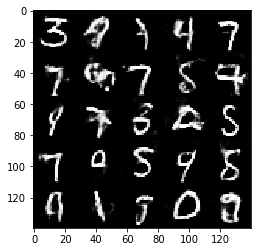

Epoch 2/2... Batch 28/32... Discriminator Loss: 1.5572... Generator Loss: 0.3294
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.9717... Generator Loss: 1.1208
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.7979... Generator Loss: 1.2829
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9659... Generator Loss: 0.8565
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.8335... Generator Loss: 1.0779
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9753... Generator Loss: 1.0350
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2268... Generator Loss: 0.6214
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.1129... Generator Loss: 0.6922
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9744... Generator Loss: 1.6780
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.7773... Generator Loss: 1.1866


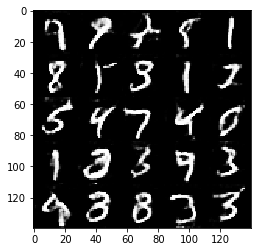

Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9572... Generator Loss: 1.0252
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.8631... Generator Loss: 1.2426
Epoch 2/2... Batch 20/32... Discriminator Loss: 1.0291... Generator Loss: 0.8490
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.1820... Generator Loss: 0.6736
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9111... Generator Loss: 0.9967
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0761... Generator Loss: 0.7227
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9222... Generator Loss: 0.8853
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.1057... Generator Loss: 0.6903
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.1173... Generator Loss: 1.0278
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.1748... Generator Loss: 0.8010


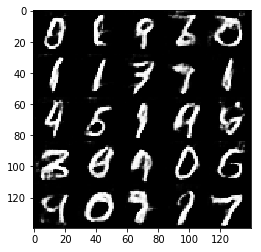

Epoch 2/2... Batch 4/32... Discriminator Loss: 1.1390... Generator Loss: 0.7433
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.2673... Generator Loss: 0.5014
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2973... Generator Loss: 0.4469
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9823... Generator Loss: 1.1490
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9793... Generator Loss: 0.7946
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.7946... Generator Loss: 1.2174
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9947... Generator Loss: 0.8337
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9675... Generator Loss: 1.4236
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.7182... Generator Loss: 1.3969
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.7181... Generator Loss: 1.3968


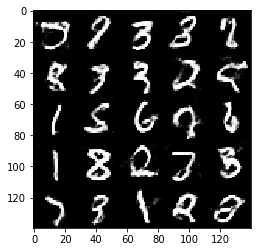

Epoch 2/2... Batch 8/32... Discriminator Loss: 1.0523... Generator Loss: 0.7026
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.8782... Generator Loss: 0.9132
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.0342... Generator Loss: 1.1372
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.9936... Generator Loss: 0.7088
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.0614... Generator Loss: 1.2957
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9894... Generator Loss: 1.7312
Epoch 2/2... Batch 4/32... Discriminator Loss: 1.0472... Generator Loss: 1.0147
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.8758... Generator Loss: 1.0133
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2151... Generator Loss: 0.6409
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.8466... Generator Loss: 1.0516


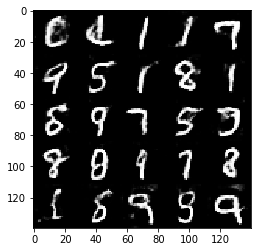

Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9289... Generator Loss: 1.3941
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.4941... Generator Loss: 0.4367
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.7409... Generator Loss: 1.4693
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.0117... Generator Loss: 0.9735
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8422... Generator Loss: 1.2077
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.7937... Generator Loss: 1.1117
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.7691... Generator Loss: 1.6191
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0169... Generator Loss: 0.8389
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9070... Generator Loss: 1.2374
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8367... Generator Loss: 1.0031


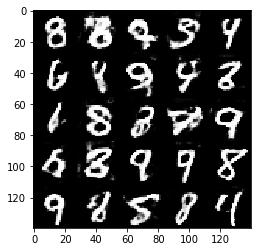

Epoch 2/2... Batch 16/32... Discriminator Loss: 1.0275... Generator Loss: 2.0209
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.8530... Generator Loss: 1.1836
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.7175... Generator Loss: 1.5493
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9059... Generator Loss: 1.0363
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.0040... Generator Loss: 0.8954
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.0754... Generator Loss: 0.6691
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9461... Generator Loss: 1.1322
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9277... Generator Loss: 1.3849
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.8144... Generator Loss: 1.1086
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.5055... Generator Loss: 0.4487


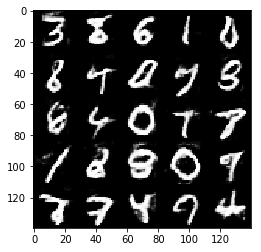

Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9156... Generator Loss: 1.1368
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0576... Generator Loss: 1.1661
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9567... Generator Loss: 1.0695
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.8604... Generator Loss: 1.8797
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8794... Generator Loss: 1.0991
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8960... Generator Loss: 1.0434
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.7914... Generator Loss: 1.0574
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9755... Generator Loss: 0.8813
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.8794... Generator Loss: 1.2164
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9029... Generator Loss: 1.8167


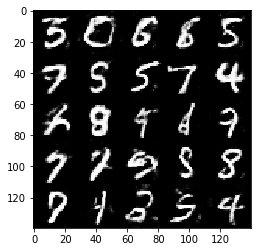

Epoch 2/2... Batch 24/32... Discriminator Loss: 0.7820... Generator Loss: 1.0961
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.0022... Generator Loss: 0.8286
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9489... Generator Loss: 0.8733
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.8576... Generator Loss: 1.0723
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.7833... Generator Loss: 1.1462
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.8390... Generator Loss: 1.2991
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.6477... Generator Loss: 1.3125
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.3739... Generator Loss: 0.5733
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.7745... Generator Loss: 1.2099
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.9943... Generator Loss: 1.0497


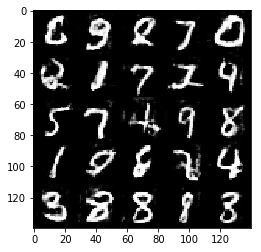

Epoch 2/2... Batch 28/32... Discriminator Loss: 0.7594... Generator Loss: 1.5467
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.9155... Generator Loss: 0.9340
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.8654... Generator Loss: 0.9931
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0963... Generator Loss: 0.6634
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.8772... Generator Loss: 1.1671
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.8502... Generator Loss: 1.4200
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.0919... Generator Loss: 0.7032
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9220... Generator Loss: 1.2055
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.7308... Generator Loss: 1.1391
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.2242... Generator Loss: 0.5112


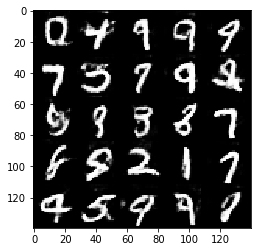

Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9517... Generator Loss: 0.7913
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9530... Generator Loss: 0.9245
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9923... Generator Loss: 0.9442
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.8353... Generator Loss: 1.4816
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9417... Generator Loss: 1.1550
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0315... Generator Loss: 0.7467
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8894... Generator Loss: 0.9811
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8509... Generator Loss: 1.1991
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.9363... Generator Loss: 1.3569
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.1762... Generator Loss: 1.1968


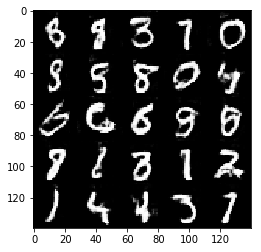

Epoch 2/2... Batch 4/32... Discriminator Loss: 0.7284... Generator Loss: 1.5553
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.8066... Generator Loss: 1.3259
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.6595... Generator Loss: 1.2651
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.3899... Generator Loss: 0.4322
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.7828... Generator Loss: 1.5849
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.8608... Generator Loss: 1.1771
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9435... Generator Loss: 1.1023
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9231... Generator Loss: 0.7862
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.6078... Generator Loss: 1.8803
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.7265... Generator Loss: 1.3418


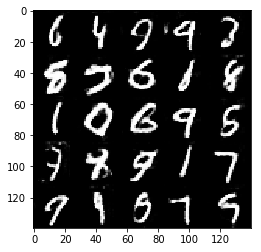

Epoch 2/2... Batch 8/32... Discriminator Loss: 0.8197... Generator Loss: 0.9884
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.7448... Generator Loss: 1.0521
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8949... Generator Loss: 0.9467
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.9550... Generator Loss: 0.6904
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.2243... Generator Loss: 0.6332
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.1604... Generator Loss: 1.0685
Epoch 2/2... Batch 4/32... Discriminator Loss: 1.1065... Generator Loss: 1.7777
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.7597... Generator Loss: 1.2121
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.8964... Generator Loss: 1.0161
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9748... Generator Loss: 0.8781


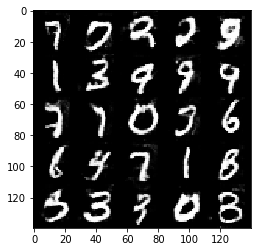

Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8177... Generator Loss: 1.2133
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.8387... Generator Loss: 1.4623
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.7833... Generator Loss: 1.0657
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9217... Generator Loss: 0.9752
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8515... Generator Loss: 1.1649
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0168... Generator Loss: 0.8276
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.7347... Generator Loss: 1.3631
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0079... Generator Loss: 0.7488
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.5425... Generator Loss: 2.1563
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.5292... Generator Loss: 2.3300


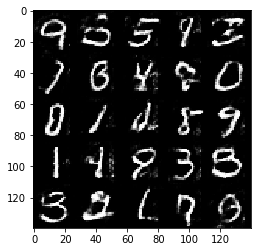

Epoch 2/2... Batch 16/32... Discriminator Loss: 1.2169... Generator Loss: 1.8209
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.6509... Generator Loss: 1.8438
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9308... Generator Loss: 0.9446
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.6860... Generator Loss: 2.0063
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.8262... Generator Loss: 1.0705
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.7006... Generator Loss: 1.1608
Epoch 2/2... Batch 12/32... Discriminator Loss: 1.0122... Generator Loss: 0.8352
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.6593... Generator Loss: 1.3697
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.6970... Generator Loss: 1.3540
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.8057... Generator Loss: 1.5875


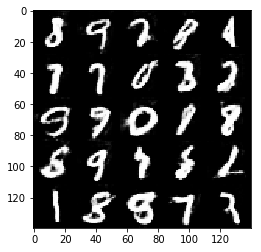

Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8680... Generator Loss: 2.0633
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.9886... Generator Loss: 1.0720
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9026... Generator Loss: 1.4536
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.1416... Generator Loss: 0.7020
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8160... Generator Loss: 1.3534


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

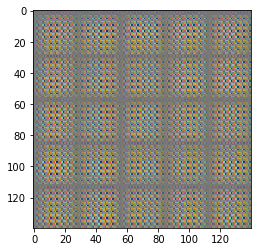

Epoch 1/1... Batch 0/128... Discriminator Loss: 2.8087... Generator Loss: 0.0708
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.7198... Generator Loss: 1.5405
Epoch 1/1... Batch 20/128... Discriminator Loss: 0.7337... Generator Loss: 2.3825
Epoch 1/1... Batch 30/128... Discriminator Loss: 0.2116... Generator Loss: 1.8517
Epoch 1/1... Batch 40/128... Discriminator Loss: 1.6306... Generator Loss: 7.3129
Epoch 1/1... Batch 50/128... Discriminator Loss: 2.0841... Generator Loss: 5.1735
Epoch 1/1... Batch 60/128... Discriminator Loss: 0.9839... Generator Loss: 3.9435
Epoch 1/1... Batch 70/128... Discriminator Loss: 1.0908... Generator Loss: 3.1675
Epoch 1/1... Batch 80/128... Discriminator Loss: 1.2215... Generator Loss: 0.4751
Epoch 1/1... Batch 90/128... Discriminator Loss: 15.0196... Generator Loss: 8.5443


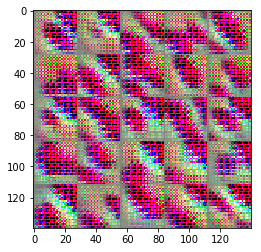

Epoch 1/1... Batch 100/128... Discriminator Loss: 433.4861... Generator Loss: 0.0000
Epoch 1/1... Batch 110/128... Discriminator Loss: 34.3537... Generator Loss: 47.9773
Epoch 1/1... Batch 120/128... Discriminator Loss: 2.4254... Generator Loss: 6.2320
Epoch 1/1... Batch 2/128... Discriminator Loss: 2.8585... Generator Loss: 2.1614
Epoch 1/1... Batch 12/128... Discriminator Loss: 0.5630... Generator Loss: 5.2703
Epoch 1/1... Batch 22/128... Discriminator Loss: 2.9725... Generator Loss: 10.3838
Epoch 1/1... Batch 32/128... Discriminator Loss: 0.6238... Generator Loss: 6.0186
Epoch 1/1... Batch 42/128... Discriminator Loss: 0.2203... Generator Loss: 5.1198
Epoch 1/1... Batch 52/128... Discriminator Loss: 0.5328... Generator Loss: 4.7112
Epoch 1/1... Batch 62/128... Discriminator Loss: 3.8045... Generator Loss: 15.8242


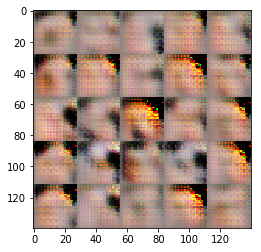

Epoch 1/1... Batch 72/128... Discriminator Loss: 0.2937... Generator Loss: 3.8539
Epoch 1/1... Batch 82/128... Discriminator Loss: 0.4895... Generator Loss: 4.4267
Epoch 1/1... Batch 92/128... Discriminator Loss: 0.7543... Generator Loss: 3.1978
Epoch 1/1... Batch 102/128... Discriminator Loss: 1.6224... Generator Loss: 5.7045
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.3042... Generator Loss: 4.3298
Epoch 1/1... Batch 122/128... Discriminator Loss: 1.3323... Generator Loss: 0.7666
Epoch 1/1... Batch 4/128... Discriminator Loss: 1.1358... Generator Loss: 0.8693
Epoch 1/1... Batch 14/128... Discriminator Loss: 1.3243... Generator Loss: 1.0185
Epoch 1/1... Batch 24/128... Discriminator Loss: 2.2815... Generator Loss: 0.3620
Epoch 1/1... Batch 34/128... Discriminator Loss: 1.9774... Generator Loss: 4.5479


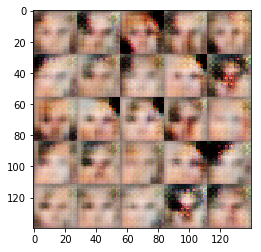

Epoch 1/1... Batch 44/128... Discriminator Loss: 1.6909... Generator Loss: 3.7534
Epoch 1/1... Batch 54/128... Discriminator Loss: 2.5502... Generator Loss: 5.8520
Epoch 1/1... Batch 64/128... Discriminator Loss: 0.9838... Generator Loss: 2.0581
Epoch 1/1... Batch 74/128... Discriminator Loss: 0.9190... Generator Loss: 1.3488
Epoch 1/1... Batch 84/128... Discriminator Loss: 0.8928... Generator Loss: 1.5651
Epoch 1/1... Batch 94/128... Discriminator Loss: 1.0850... Generator Loss: 1.4991
Epoch 1/1... Batch 104/128... Discriminator Loss: 1.1532... Generator Loss: 0.9100
Epoch 1/1... Batch 114/128... Discriminator Loss: 1.3818... Generator Loss: 3.1827
Epoch 1/1... Batch 124/128... Discriminator Loss: 0.7762... Generator Loss: 1.6307
Epoch 1/1... Batch 6/128... Discriminator Loss: 0.8568... Generator Loss: 1.4288


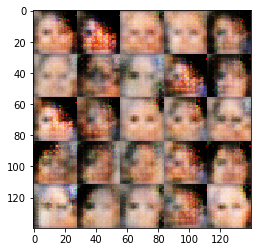

Epoch 1/1... Batch 16/128... Discriminator Loss: 1.1281... Generator Loss: 1.5006
Epoch 1/1... Batch 26/128... Discriminator Loss: 0.8953... Generator Loss: 0.9400
Epoch 1/1... Batch 36/128... Discriminator Loss: 2.3809... Generator Loss: 5.1544
Epoch 1/1... Batch 46/128... Discriminator Loss: 1.0971... Generator Loss: 1.7865
Epoch 1/1... Batch 56/128... Discriminator Loss: 1.2068... Generator Loss: 0.6935
Epoch 1/1... Batch 66/128... Discriminator Loss: 1.1113... Generator Loss: 0.5853
Epoch 1/1... Batch 76/128... Discriminator Loss: 0.9379... Generator Loss: 1.7696
Epoch 1/1... Batch 86/128... Discriminator Loss: 0.8993... Generator Loss: 1.0639
Epoch 1/1... Batch 96/128... Discriminator Loss: 0.9013... Generator Loss: 2.0008
Epoch 1/1... Batch 106/128... Discriminator Loss: 0.9536... Generator Loss: 0.8885


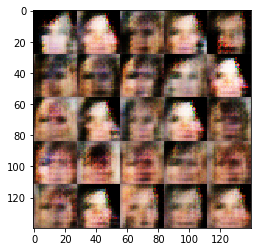

Epoch 1/1... Batch 116/128... Discriminator Loss: 0.9536... Generator Loss: 0.9734
Epoch 1/1... Batch 126/128... Discriminator Loss: 0.9731... Generator Loss: 1.0331
Epoch 1/1... Batch 8/128... Discriminator Loss: 0.9773... Generator Loss: 1.0972
Epoch 1/1... Batch 18/128... Discriminator Loss: 0.8192... Generator Loss: 1.3031
Epoch 1/1... Batch 28/128... Discriminator Loss: 1.0469... Generator Loss: 1.6056
Epoch 1/1... Batch 38/128... Discriminator Loss: 0.9128... Generator Loss: 1.1143
Epoch 1/1... Batch 48/128... Discriminator Loss: 0.9560... Generator Loss: 1.3141
Epoch 1/1... Batch 58/128... Discriminator Loss: 0.9261... Generator Loss: 0.7934
Epoch 1/1... Batch 68/128... Discriminator Loss: 1.0082... Generator Loss: 0.9432
Epoch 1/1... Batch 78/128... Discriminator Loss: 1.9658... Generator Loss: 3.3615


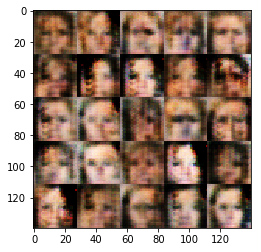

Epoch 1/1... Batch 88/128... Discriminator Loss: 0.9693... Generator Loss: 1.0982
Epoch 1/1... Batch 98/128... Discriminator Loss: 1.0202... Generator Loss: 0.8682
Epoch 1/1... Batch 108/128... Discriminator Loss: 0.8289... Generator Loss: 1.5769
Epoch 1/1... Batch 118/128... Discriminator Loss: 0.8378... Generator Loss: 1.5087
Epoch 1/1... Batch 0/128... Discriminator Loss: 0.8844... Generator Loss: 1.1260
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.1703... Generator Loss: 0.5780
Epoch 1/1... Batch 20/128... Discriminator Loss: 0.9108... Generator Loss: 1.1344
Epoch 1/1... Batch 30/128... Discriminator Loss: 1.1527... Generator Loss: 0.6330
Epoch 1/1... Batch 40/128... Discriminator Loss: 0.8366... Generator Loss: 1.3792
Epoch 1/1... Batch 50/128... Discriminator Loss: 1.1377... Generator Loss: 0.7970


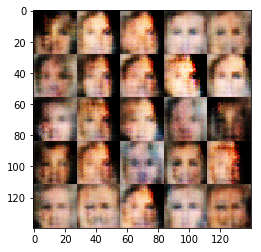

Epoch 1/1... Batch 60/128... Discriminator Loss: 0.8157... Generator Loss: 0.9523
Epoch 1/1... Batch 70/128... Discriminator Loss: 0.8814... Generator Loss: 1.4574
Epoch 1/1... Batch 80/128... Discriminator Loss: 0.9491... Generator Loss: 1.6143
Epoch 1/1... Batch 90/128... Discriminator Loss: 0.7700... Generator Loss: 1.8609
Epoch 1/1... Batch 100/128... Discriminator Loss: 0.9239... Generator Loss: 0.9756
Epoch 1/1... Batch 110/128... Discriminator Loss: 0.7843... Generator Loss: 1.1769
Epoch 1/1... Batch 120/128... Discriminator Loss: 0.9287... Generator Loss: 0.9599
Epoch 1/1... Batch 2/128... Discriminator Loss: 0.9896... Generator Loss: 0.8944
Epoch 1/1... Batch 12/128... Discriminator Loss: 0.9609... Generator Loss: 0.9959
Epoch 1/1... Batch 22/128... Discriminator Loss: 0.9592... Generator Loss: 0.8471


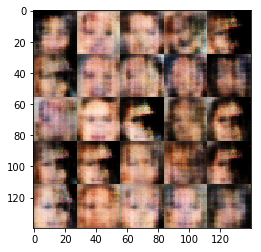

Epoch 1/1... Batch 32/128... Discriminator Loss: 0.9452... Generator Loss: 2.7494
Epoch 1/1... Batch 42/128... Discriminator Loss: 0.9615... Generator Loss: 1.1900
Epoch 1/1... Batch 52/128... Discriminator Loss: 1.1098... Generator Loss: 1.6854
Epoch 1/1... Batch 62/128... Discriminator Loss: 1.3573... Generator Loss: 2.4008
Epoch 1/1... Batch 72/128... Discriminator Loss: 0.7484... Generator Loss: 2.1481
Epoch 1/1... Batch 82/128... Discriminator Loss: 1.0325... Generator Loss: 2.9567
Epoch 1/1... Batch 92/128... Discriminator Loss: 1.0498... Generator Loss: 1.0785
Epoch 1/1... Batch 102/128... Discriminator Loss: 0.8504... Generator Loss: 1.4951
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.0341... Generator Loss: 1.0649
Epoch 1/1... Batch 122/128... Discriminator Loss: 0.8658... Generator Loss: 1.5176


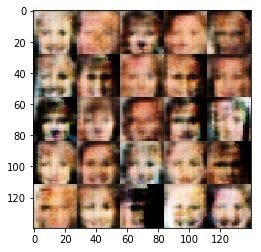

Epoch 1/1... Batch 4/128... Discriminator Loss: 0.9977... Generator Loss: 1.0242
Epoch 1/1... Batch 14/128... Discriminator Loss: 0.9715... Generator Loss: 2.0821
Epoch 1/1... Batch 24/128... Discriminator Loss: 0.8401... Generator Loss: 1.3720
Epoch 1/1... Batch 34/128... Discriminator Loss: 0.9824... Generator Loss: 0.9889
Epoch 1/1... Batch 44/128... Discriminator Loss: 0.9063... Generator Loss: 1.1363
Epoch 1/1... Batch 54/128... Discriminator Loss: 0.9250... Generator Loss: 1.6657
Epoch 1/1... Batch 64/128... Discriminator Loss: 0.8769... Generator Loss: 1.0956
Epoch 1/1... Batch 74/128... Discriminator Loss: 0.9402... Generator Loss: 1.2887
Epoch 1/1... Batch 84/128... Discriminator Loss: 1.0170... Generator Loss: 2.0578
Epoch 1/1... Batch 94/128... Discriminator Loss: 1.1450... Generator Loss: 0.8490


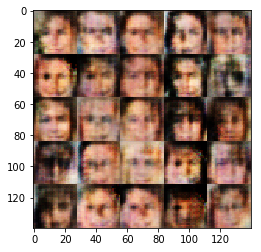

Epoch 1/1... Batch 104/128... Discriminator Loss: 1.0988... Generator Loss: 2.0495
Epoch 1/1... Batch 114/128... Discriminator Loss: 0.7958... Generator Loss: 1.3108
Epoch 1/1... Batch 124/128... Discriminator Loss: 1.1229... Generator Loss: 2.1354
Epoch 1/1... Batch 6/128... Discriminator Loss: 0.9208... Generator Loss: 1.3686
Epoch 1/1... Batch 16/128... Discriminator Loss: 1.0811... Generator Loss: 1.1610
Epoch 1/1... Batch 26/128... Discriminator Loss: 2.0379... Generator Loss: 3.1969
Epoch 1/1... Batch 36/128... Discriminator Loss: 1.0074... Generator Loss: 2.0422
Epoch 1/1... Batch 46/128... Discriminator Loss: 1.0066... Generator Loss: 1.6947
Epoch 1/1... Batch 56/128... Discriminator Loss: 0.8825... Generator Loss: 1.4168
Epoch 1/1... Batch 66/128... Discriminator Loss: 0.9394... Generator Loss: 1.8724


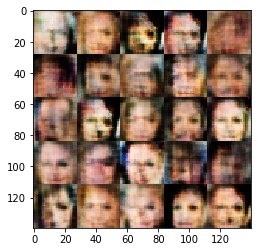

Epoch 1/1... Batch 76/128... Discriminator Loss: 0.8499... Generator Loss: 1.7022
Epoch 1/1... Batch 86/128... Discriminator Loss: 0.9557... Generator Loss: 2.2388
Epoch 1/1... Batch 96/128... Discriminator Loss: 0.9176... Generator Loss: 1.0714
Epoch 1/1... Batch 106/128... Discriminator Loss: 1.3294... Generator Loss: 0.4583
Epoch 1/1... Batch 116/128... Discriminator Loss: 1.0537... Generator Loss: 0.8510
Epoch 1/1... Batch 126/128... Discriminator Loss: 1.0410... Generator Loss: 1.6741
Epoch 1/1... Batch 8/128... Discriminator Loss: 1.0208... Generator Loss: 1.4585
Epoch 1/1... Batch 18/128... Discriminator Loss: 0.9291... Generator Loss: 1.1983
Epoch 1/1... Batch 28/128... Discriminator Loss: 1.0863... Generator Loss: 0.9513
Epoch 1/1... Batch 38/128... Discriminator Loss: 0.8756... Generator Loss: 1.3063


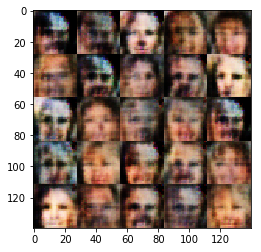

Epoch 1/1... Batch 48/128... Discriminator Loss: 1.0089... Generator Loss: 1.4420
Epoch 1/1... Batch 58/128... Discriminator Loss: 1.4061... Generator Loss: 3.4658
Epoch 1/1... Batch 68/128... Discriminator Loss: 1.0293... Generator Loss: 1.2149
Epoch 1/1... Batch 78/128... Discriminator Loss: 1.1399... Generator Loss: 0.8339
Epoch 1/1... Batch 88/128... Discriminator Loss: 1.1177... Generator Loss: 1.3467
Epoch 1/1... Batch 98/128... Discriminator Loss: 0.9854... Generator Loss: 1.0559
Epoch 1/1... Batch 108/128... Discriminator Loss: 0.9565... Generator Loss: 1.4876
Epoch 1/1... Batch 118/128... Discriminator Loss: 0.8387... Generator Loss: 1.0744
Epoch 1/1... Batch 0/128... Discriminator Loss: 1.0066... Generator Loss: 1.2388
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.1073... Generator Loss: 1.2381


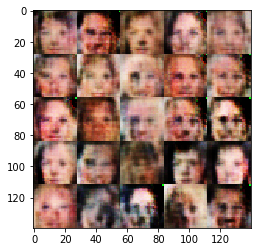

Epoch 1/1... Batch 20/128... Discriminator Loss: 1.1605... Generator Loss: 1.4874
Epoch 1/1... Batch 30/128... Discriminator Loss: 0.9547... Generator Loss: 0.8224
Epoch 1/1... Batch 40/128... Discriminator Loss: 1.0409... Generator Loss: 1.0143
Epoch 1/1... Batch 50/128... Discriminator Loss: 0.8735... Generator Loss: 1.3241
Epoch 1/1... Batch 60/128... Discriminator Loss: 0.9064... Generator Loss: 1.3533
Epoch 1/1... Batch 70/128... Discriminator Loss: 0.9714... Generator Loss: 1.2622
Epoch 1/1... Batch 80/128... Discriminator Loss: 1.0334... Generator Loss: 0.7880
Epoch 1/1... Batch 90/128... Discriminator Loss: 0.9729... Generator Loss: 0.8934
Epoch 1/1... Batch 100/128... Discriminator Loss: 0.9619... Generator Loss: 1.1193
Epoch 1/1... Batch 110/128... Discriminator Loss: 0.9844... Generator Loss: 1.0418


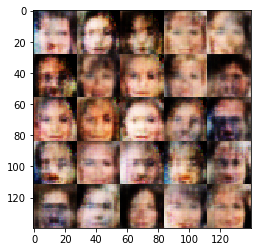

Epoch 1/1... Batch 120/128... Discriminator Loss: 1.2524... Generator Loss: 1.8040
Epoch 1/1... Batch 2/128... Discriminator Loss: 1.1689... Generator Loss: 0.6091
Epoch 1/1... Batch 12/128... Discriminator Loss: 0.8902... Generator Loss: 1.1166
Epoch 1/1... Batch 22/128... Discriminator Loss: 1.0352... Generator Loss: 1.4904
Epoch 1/1... Batch 32/128... Discriminator Loss: 1.0273... Generator Loss: 0.8074
Epoch 1/1... Batch 42/128... Discriminator Loss: 1.1905... Generator Loss: 0.7543
Epoch 1/1... Batch 52/128... Discriminator Loss: 1.1373... Generator Loss: 0.7231
Epoch 1/1... Batch 62/128... Discriminator Loss: 1.0997... Generator Loss: 1.9881
Epoch 1/1... Batch 72/128... Discriminator Loss: 1.1271... Generator Loss: 0.7800
Epoch 1/1... Batch 82/128... Discriminator Loss: 1.1018... Generator Loss: 1.6612


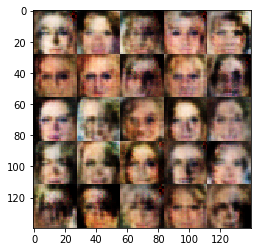

Epoch 1/1... Batch 92/128... Discriminator Loss: 1.2265... Generator Loss: 0.6372
Epoch 1/1... Batch 102/128... Discriminator Loss: 1.0917... Generator Loss: 1.4223
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.0382... Generator Loss: 0.9294
Epoch 1/1... Batch 122/128... Discriminator Loss: 3.3526... Generator Loss: 4.1748
Epoch 1/1... Batch 4/128... Discriminator Loss: 1.2569... Generator Loss: 0.9948
Epoch 1/1... Batch 14/128... Discriminator Loss: 0.9622... Generator Loss: 1.1175
Epoch 1/1... Batch 24/128... Discriminator Loss: 1.0322... Generator Loss: 1.3698
Epoch 1/1... Batch 34/128... Discriminator Loss: 1.0228... Generator Loss: 0.8353
Epoch 1/1... Batch 44/128... Discriminator Loss: 1.0450... Generator Loss: 0.8928


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.003
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.